안녕하세요. XGBoost Regressor 와 간단한 feature selection 을 이용한 코드입니다. 상세 설명은 코드의 주석을 참고 바랍니다. 혹시 질문이나 잘못된 부분에 대해 덧글 부탁드립니다. 감사합니다.

# 1. 구현 환경

# 2. 패키지

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1' # 사용하려는 GPU 번호
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import IPython.display as ipd
%matplotlib inline

# 3. 상수 설정

Standardizatino 과 min-max scaling 모두 적용해보았으나 아무것도 적용하지 않은 경우 점수가 더 높았습니다.

In [2]:
SCALE = False

# 4. 데이터 불러오기

In [3]:
trainset = pd.read_csv('train.csv')

In [4]:
# 결측치 확인
np.sum(trainset.isna())

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
number_of_rentals            0
dtype: int64

In [5]:
testset = pd.read_csv('test.csv')

In [6]:
# 결측치 확인
np.sum(testset.isna())

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
dtype: int64

In [7]:
# 최종 제출을 위한 dataframe 불러오기
submission = pd.read_csv('sample_submission.csv')

원본 dataframe 의 date_time 칼럼은 기계학습 알고리즘에 그대로 적용하기에 정보가 부족합니다. 그래서 정보를 상세하게 풀어서 추가해주었습니다. 
* week: 연도 별로 몇째 주 마다 이용자가 다를 수 있으므로 요일 정보를 추가해줍니다.
* weekday: 요일별로 따릉이 이용자가 다를 수 있으므로 요일 정보를 추가해줍니다.
* <b>추가 해볼 수 있는 것: 평일 / 주말 이용자가 다를 수 있으므로 평일과 주말에 대한 칼럼도 추가해주면 성능 향상에 도움이 될 듯 합니다.</b>

In [8]:
def split_date(df):
    '''
    args
        df: 원본 데이터프레임
    return
        year, month, day, week, weekday 정보를 추가한 dataframe
    '''
    df['year'] = pd.to_datetime(df['date_time']).dt.year
    df['month'] = pd.to_datetime(df['date_time']).dt.month
    df['day'] = pd.to_datetime(df['date_time']).dt.day
    df['week'] = pd.to_datetime(df['date_time']).dt.week
    df['weekday'] = pd.to_datetime(df['date_time']).dt.weekday
    # df['quarter'] = pd.to_datetime(df['date_time']).dt.quarter # 데이터는 모두 동일 분기 데이터이므로 무의미
    
    return df.drop(columns=['date_time'])

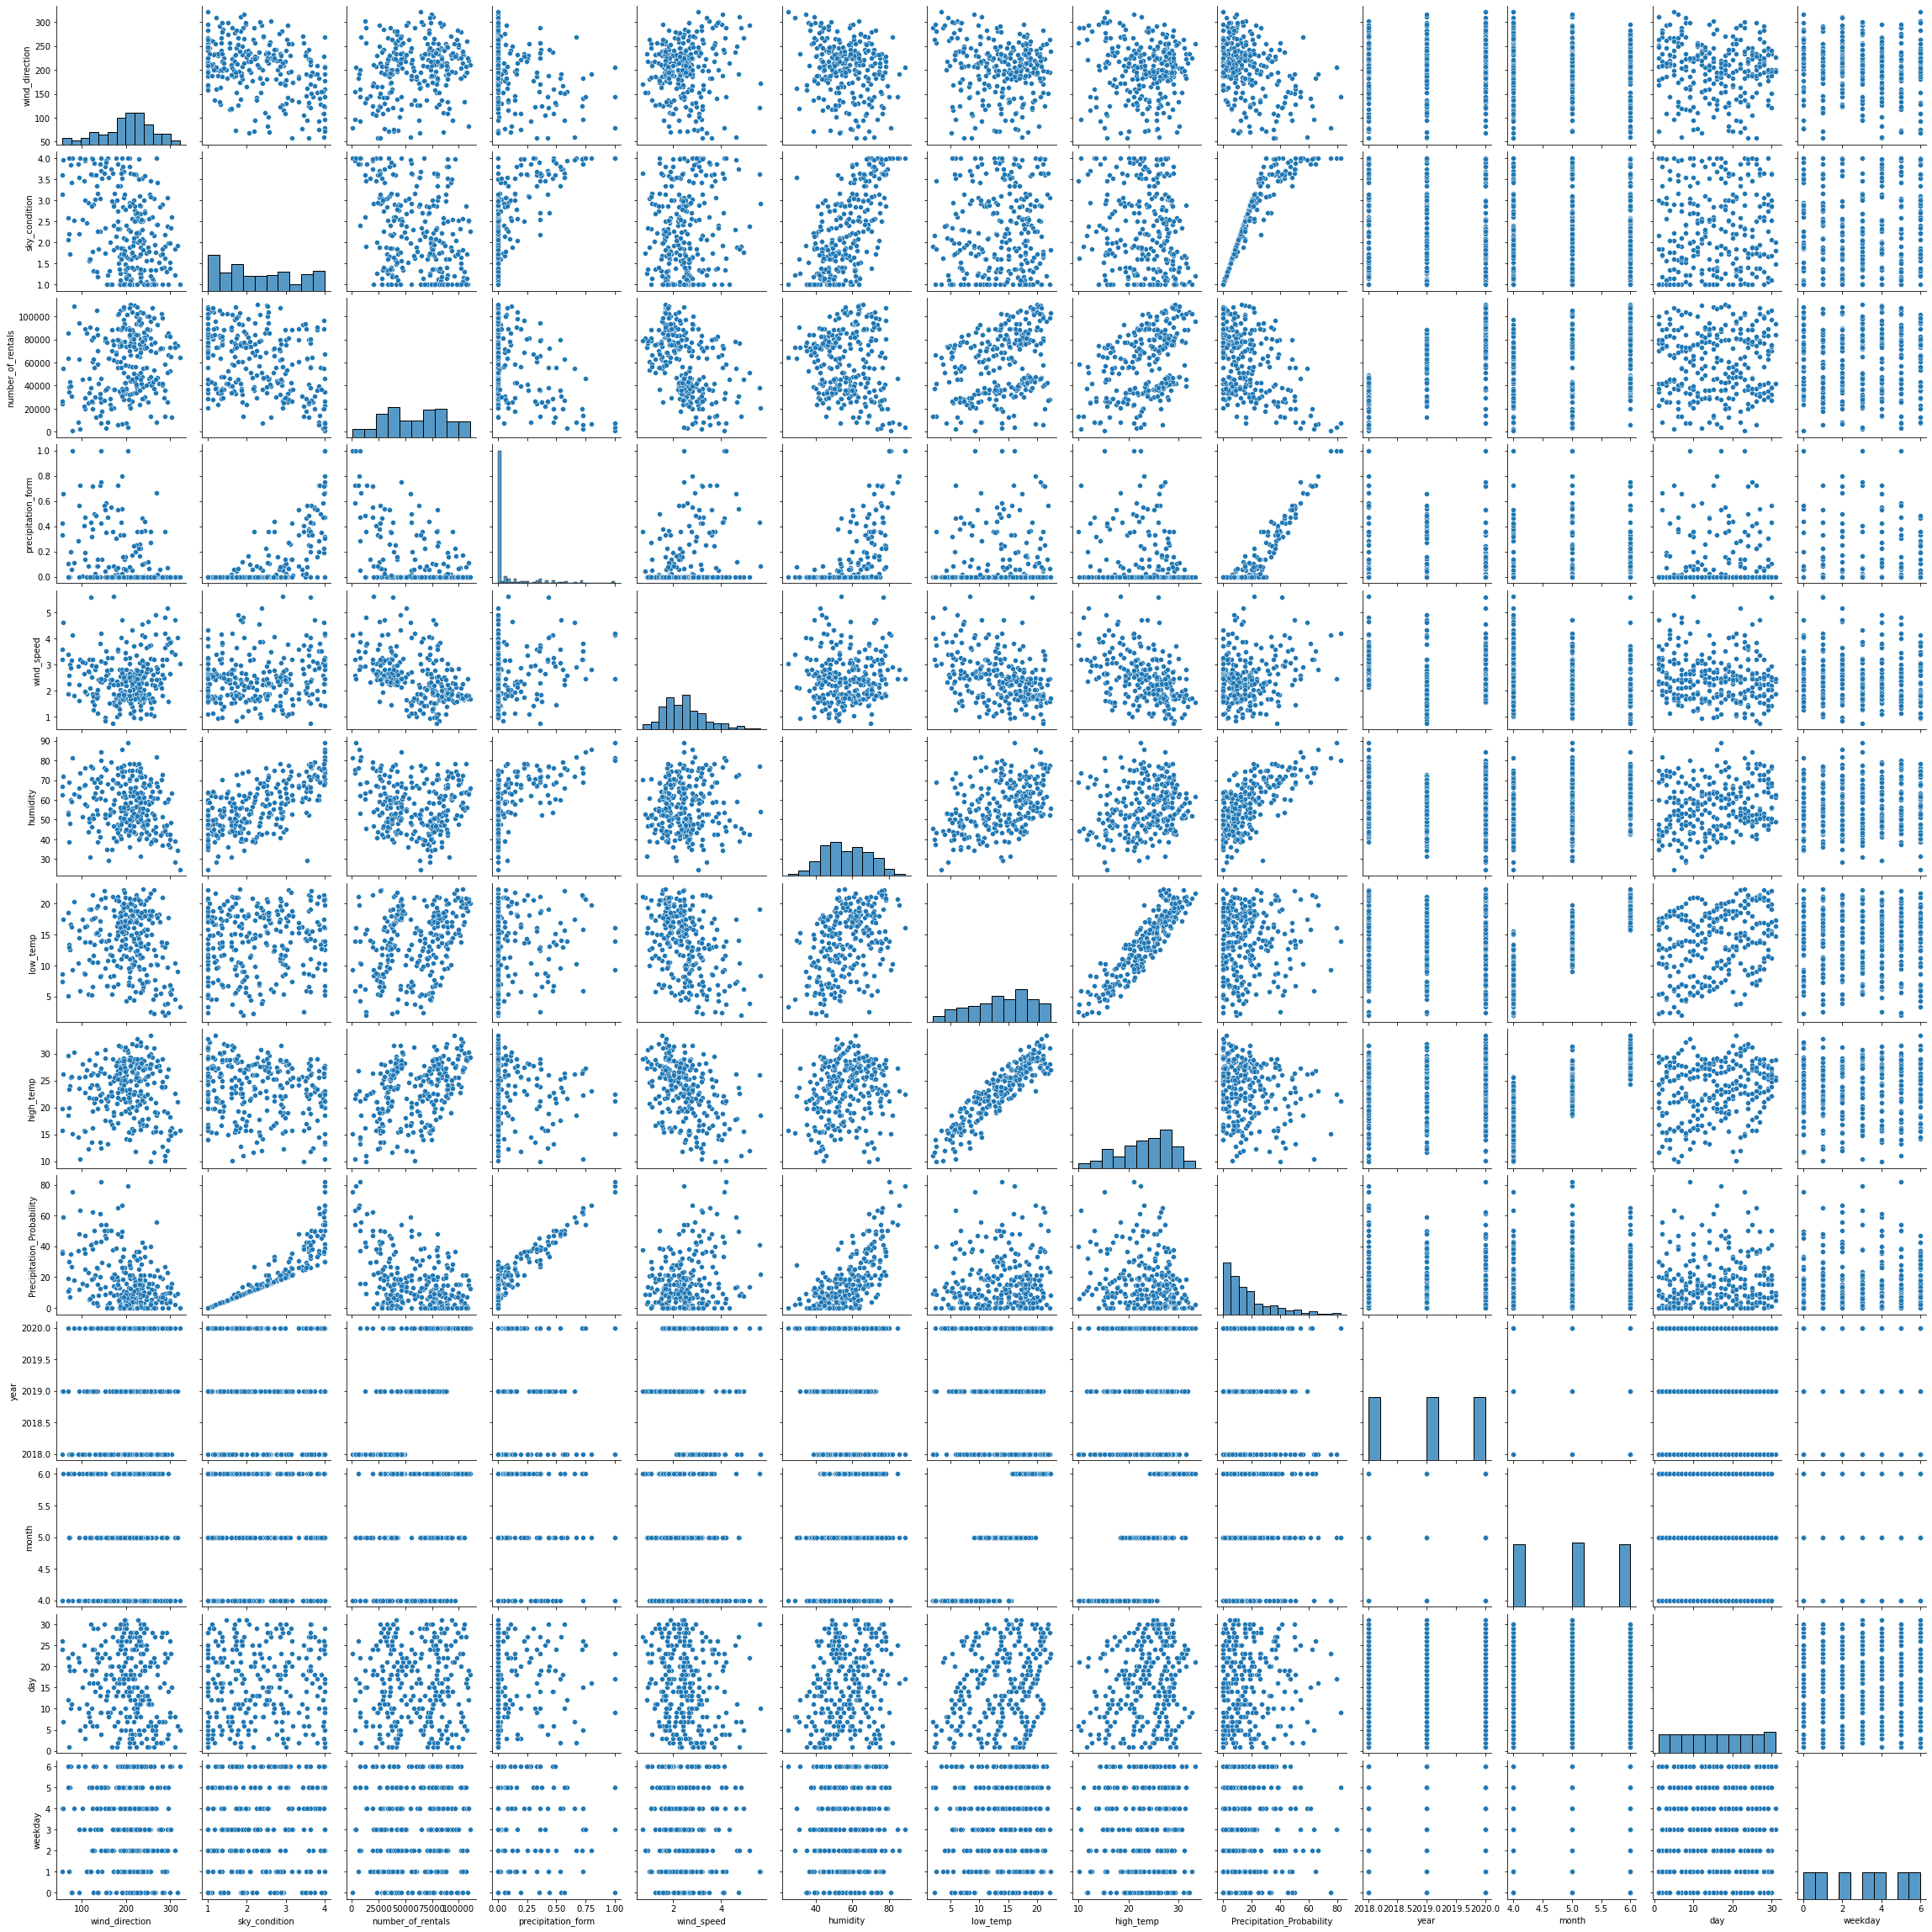

In [50]:
# import seaborn as  sns
# import matplotlib.pyplot as plt
# sns.pairplot(trainset[["wind_direction","sky_condition","number_of_rentals","precipitation_form","wind_speed","humidity","low_temp","high_temp","Precipitation_Probability","year","month","day","weekday"]])
# # sns.pairplot(trainset[["wind_direction","sky_condition", "precipitation_form","wind_speed","humidity","low_temp","high_temp","Precipitation_Probability","number_of_rentals","year","month","day","weekday","number_of_rentals"]])
# plt.show()

In [9]:
traindf = split_date(trainset)
testdf = split_date(testset)

In [10]:
keys = traindf.drop(columns=['number_of_rentals']).keys()

In [11]:
traindf.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,week,weekday
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,13,6
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,14,0
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,14,1
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,14,2
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,14,3


In [12]:
testdf.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,week,weekday
0,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1,13,3
1,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2,13,4
2,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3,13,5
3,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4,13,6
4,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5,14,0


In [13]:
keydict = dict()
for i, k in enumerate(keys):
    keydict[i]=k

데이터 학습을 위해 입력값과 출력값을 분리해줍니다.

In [14]:
X = np.array(traindf.drop(columns=['number_of_rentals'])).astype(float)
y = np.array(traindf['number_of_rentals']).astype(float)
X_test = np.array(testdf).astype(float)

if SCALE:
    x_max = np.max(X, 0)
    y_max = np.max(y, 0)
    X /= x_max
    y /= y_max
    X_test /= x_max

# 5. 유틸리티

In [15]:
def nmae(true, pred):
    return np.mean(np.abs(true-pred)/true)

성능 확인을 위해서 몬테카를로 교차검증을 사용합니다([링크](https://en.wikipedia.org/wiki/Cross-validation_(statistics)의 섹션 Repeated random sub-sampling validation 참고).

In [16]:
def cv(model, X=X, y=y, cnt=100, test_size=.5):
    score = list()
    seeds = np.random.choice(np.arange(1e5), size=cnt, replace=False)
    for seed in seeds:
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        if SCALE:
            y_pred *= y_max
            y_valid *= y_max
        score.append(nmae(y_valid, y_pred))
    return np.mean(score)

# 6. Feature selection

제거 법을 이용해서 feature selection 을 해봅니다.

In [17]:
def select_features(X, cols):
    _X = list()
    for c in cols:
        _X.append(np.expand_dims(X[:, c],-1))
    return np.concatenate(_X, axis=1)

In [18]:
keydict

{0: 'wind_direction',
 1: 'sky_condition',
 2: 'precipitation_form',
 3: 'wind_speed',
 4: 'humidity',
 5: 'low_temp',
 6: 'high_temp',
 7: 'Precipitation_Probability',
 8: 'year',
 9: 'month',
 10: 'day',
 11: 'week',
 12: 'weekday'}

다양한 모델 확인 결과 XGBRegressor 가 가장 좋아서 이걸 선택했습니다.

In [19]:
from xgboost import XGBRegressor as Model

In [20]:
min_loss = 1e10
min_cols = None

for i in np.arange(start=0, stop=len(keys)):
#     model = Model(tree_method='gpu_hist')
#     model = Model(silent = 1)
    model = Model(eta = 0.1)
    cols = np.arange(len(keys))
    cols = np.delete(cols, i)
    _X = select_features(X, cols)
    loss = cv(model, _X, y, cnt=30)
    if min_loss > loss:
        min_loss = loss
        min_cols = f"{keydict.get(i)}"
    print(f"{keydict.get(i)}, {loss:.4f} (min {min_loss:.4f})")

wind_direction, 0.2395 (min 0.2395)
sky_condition, 0.2440 (min 0.2395)
precipitation_form, 0.2307 (min 0.2307)
wind_speed, 0.2450 (min 0.2307)
humidity, 0.2197 (min 0.2197)
low_temp, 0.2467 (min 0.2197)
high_temp, 0.2624 (min 0.2197)
Precipitation_Probability, 0.2421 (min 0.2197)
year, 0.5008 (min 0.2197)
month, 0.2250 (min 0.2197)
day, 0.2300 (min 0.2197)
week, 0.2413 (min 0.2197)
weekday, 0.2371 (min 0.2197)


In [21]:
for i in np.arange(start=0, stop=len(keys)-1):
    for j in np.arange(start=i+1, stop=len(keys)):
#         model = Model(tree_method='gpu_hist')
        model = Model(eta = 0.1)
        cols = np.arange(len(keys))
        cols = np.delete(cols, [i,j])
        _X = select_features(X, cols)
        loss = cv(model, _X, y, cnt=30)
        if min_loss > loss:
            min_loss = loss
            min_cols = f"{keydict.get(i)}, {keydict.get(j)}"
        print(f"{keydict.get(i)}, {keydict.get(j)}, {loss:.4f} (min {min_loss:.4f})")

wind_direction, sky_condition, 0.2474 (min 0.2197)
wind_direction, precipitation_form, 0.2484 (min 0.2197)
wind_direction, wind_speed, 0.2349 (min 0.2197)
wind_direction, humidity, 0.2270 (min 0.2197)
wind_direction, low_temp, 0.2285 (min 0.2197)
wind_direction, high_temp, 0.2377 (min 0.2197)
wind_direction, Precipitation_Probability, 0.2510 (min 0.2197)
wind_direction, year, 0.4914 (min 0.2197)
wind_direction, month, 0.2443 (min 0.2197)
wind_direction, day, 0.2389 (min 0.2197)
wind_direction, week, 0.2470 (min 0.2197)
wind_direction, weekday, 0.2303 (min 0.2197)
sky_condition, precipitation_form, 0.2589 (min 0.2197)
sky_condition, wind_speed, 0.2477 (min 0.2197)
sky_condition, humidity, 0.2281 (min 0.2197)
sky_condition, low_temp, 0.2269 (min 0.2197)
sky_condition, high_temp, 0.2407 (min 0.2197)
sky_condition, Precipitation_Probability, 0.2419 (min 0.2197)
sky_condition, year, 0.4633 (min 0.2197)
sky_condition, month, 0.2373 (min 0.2197)
sky_condition, day, 0.2525 (min 0.2197)
sky_con

0: 'wind_direction' 과  7: 'Precipitation_Probability' 가 없을 때 성능이 좋을듯 합니다. 풍향은 자전거 이용에 영향을 미치는 변수가 아닐 듯 합니다. 한편, 강수확률(Precipitation_Probability)은 관측치가 아니라 기상청 예측치라면, 예측 오류가 우리가 만드는 최종 모델의 오류를 더 커지게 할 수 있기 때문에 빼는 것이 좋겠습니다.

In [53]:
trainset.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,week,weekday
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,13,6
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,14,0
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,14,1
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,14,2
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,14,3


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

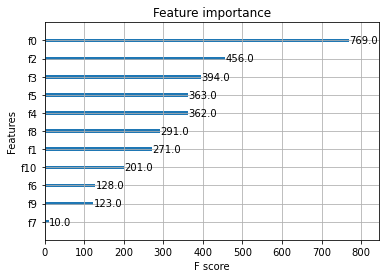

In [52]:
from xgboost import plot_importance

plot_importance(model)

## min_loss = 0.2197


# 7. 모델 학습

In [22]:
model = Model(eta = 0.1)

cols = np.arange(len(keys))
cols = np.delete(cols, [0,7]) # 풍향, 강수확률 제거
_X = select_features(X, cols)

model.fit(_X, y)

_X_test = select_features(X_test, cols)
y_pred = model.predict(_X_test)
if SCALE:
    y_pred *= y_max
y_pred = y_pred.astype(int)

# plt.scatter(np.arange(len(y_pred)), y_pred, s=.5)
# plt.show()

In [23]:
submission['number_of_rentals'] = y_pred

In [25]:
submission.to_csv('0.1-no-feeling-hyperparam-copy_xgboost_submission.csv', index=False)

# score =0.4956833938	( eta = 0.1)
# score =0.4987798086	(eta = 0.05)D